# Alternating Least Squares

### Sintesis: 

Sea $r_{ui}$ la cantidad de veces que el usuario $u$ vio el contenido $i$,

Llamamos $p_{ui} \in (0, 1)$ a la preferencia del usuario $u$ al item $i$, donde
* $p_{ui} = 1 \leftrightarrow r_{ui} > 0$,
* $p_{ui} = 0 \leftrightarrow r_{ui} = 0$

Entonces, si el usuario $u$ no vio el contenido $i$ asumimos que no hay preferencia ($r_{ui} = 0 \rightarrow p_{ui} = 0$), con un cierto nivel de confianza $C_{ui}$.

El nivel de confianza $C_{ui}$, mide la confianza de observar el $p_{ui}$ estimado, y es directamente proporcional a $r_{ui}$.

$$C_{ui} = 1 + \alpha r_{ui}$$

Nuestro objetivo es encontrar un vector $x_u \in \Re^f$ por cada usuario $u$, y un vector $y_i \in \Re^f$ por cada item $i$ que factorice las preferencias de la siguiente forma...

$$\hat r_{ui} = x_u^T y_i$$

Como el error que se usa es Least Squared Error, los factores se calculan minimizando la siguiente funcion de costo:

$$\min x^*, y^* \sum_{u,i} c_{ui}(p_{ui}-x_u^Ty_i)^2 + \lambda(\sum_u ||x_u||^2 + \sum_i ||y_i||^2)$$

Podemos ver la similaridad entre dos items $i, j$ desde la perspectiva del usuario $u$ como $s_{ij}^u = y_i^T W^u y_j$,<br>

Donde $W_u = (Y^T C^u Y + \lambda I)^{-1} \in \Re^{f x f}$ y $C^u$ es una matriz diagonal $n * n$ con $C^u_{ii} = c_{ui}$

Y vale el estimador $\hat p_{ui} = \sum_{j:r_{uj}>0} s_{ij}^u c_{uj}$

In [29]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, DataFrame
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import *

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

from models.utils import uutils
from models.interpreter import Interpreter

## [1] Lectura de datos

In [3]:
load_options = {"table": "view_events", "keyspace": "clarovideo"}
df = spark.read.format("org.apache.spark.sql.cassandra").options(**load_options).load()

In [4]:
dataset = df.withColumn("view", lit(1))
dataset.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- event: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- group_id: integer (nullable = true)
 |-- view: integer (nullable = false)



In [5]:
## ACA DEBERIA ELIMINAR DEL DS CONTENIDO QUE NUNCA SE RECOMIENDA (ej. Contenido que no es C1)

In [6]:
print("Hay %d interaciones en el dataset!" % dataset.count())

Hay 2927260 interaciones en el dataset!


In [7]:
(train, test) = dataset.randomSplit([.8, .2]) 

In [8]:
train.show(5)

+-------+-----+-------------------+--------+----+
|user_id|event|         event_time|group_id|view|
+-------+-----+-------------------+--------+----+
|2053736| view|2023-05-16 13:46:27| 1029761|   1|
|2053736| view|2023-05-19 09:33:22| 1118573|   1|
|2053736| view|2023-05-19 10:08:38| 1071265|   1|
|2053789| view|2023-05-21 13:35:08|  633407|   1|
|2054609| view|2023-05-22 22:32:36|  526833|   1|
+-------+-----+-------------------+--------+----+
only showing top 5 rows



## [2] Parametros del modelo

In [9]:
als = ALS(maxIter=5,
          rank=5,
          regParam=0.01,
          userCol='user_id',
          itemCol='group_id',
          ratingCol='view',
          implicitPrefs=True
         )

## [3] Entrenamiento del modelo

In [10]:
model = als.fit(train)

## [4] Predicciones

### Recomendar items a usuarios

In [23]:
all_users_recommendations = model.recommendForAllUsers(10)
all_users_recommendations.show(3)

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|2043074|[{1118573, 2.5434...|
|2060621|[{1119066, 0.1128...|
|2066657|[{724938, 0.03825...|
+-------+--------------------+
only showing top 3 rows



In [11]:
def get_user_recommendations(recommendations, user_id) -> list:
    return recommendations[recommendations.user_id == user_id].collect()[0][1]

# get_user_recommendations(all_users_recommendations, user_id=2043074)[:3]

### Recomendar usuarios a items

In [27]:
all_item_recommendations = model.recommendForAllItems(10)
all_item_recommendations.show(3)

+--------+--------------------+
|group_id|     recommendations|
+--------+--------------------+
|  529800|[{82346593, 0.002...|
|  529827|[{82346593, 0.002...|
|  529830|[{81677492, 0.002...|
+--------+--------------------+
only showing top 3 rows



In [12]:
def get_item_recommendations(recommendations, group_id) -> list:
    return recommendations[recommendations.group_id == group_id].collect()[0][1]

# get_item_recommendations(all_item_recommendations, group_id=1113109)[:3]

### Recomendar items similares

#### Approach 1: Distancia Euclidiana

Sea el item $i$, quiero ver cuales son los $k$ items con factores mas cercanos a $y_i$.

Usando la distacia euclidiana entre dos items $i$, $j$...

$$d(y_i, y_j) = \sqrt {\sum_{k = 1}^f (y_{ik} - y_{jk})^2}$$

Armo un nuevo dataframe con una columna "difference" con los $d(y_i, y_j)$ para cada item $j$ en models.itemFactors.

Luego, ordeno el df a partir de esa columna de forma ascendente, y tomo los primeros $k$ group_ids

In [13]:
def recommend_similar_items_v1(model, group_id):
    # Recomiendo items para el item dado, con distancia euclidiana

    # leo los factores latentes del item
    y_i = model.itemFactors.filter(model.itemFactors.id == group_id).select("features").collect()[0][0]

    # armo una columna con las diferencias entre los factores de cada item y los del item dado 
    differencer = udf(lambda x: sum([(list(x)[k]-y_i[k])**2  for k in range(len(list(x)))]), FloatType())
    distances = model.itemFactors.withColumn('difference', differencer('features'))
    
    return distances.orderBy(col('difference'))

In [14]:
model.itemFactors.show(3)

+------+--------------------+
|    id|            features|
+------+--------------------+
|526420|[8.499692E-15, 7....|
|526480|[3.8600556E-5, -4...|
|526640|[9.855362E-5, -7....|
+------+--------------------+
only showing top 3 rows



In [15]:
item_id = 526420
recommend_similar_items_v1(model, item_id).show(10)

+-------+--------------------+-------------+
|     id|            features|   difference|
+-------+--------------------+-------------+
| 526420|[8.499692E-15, 7....|          0.0|
| 572762|[4.3156977E-15, 1...| 4.157289E-29|
|1113899|[5.501991E-15, 8....|1.0777146E-28|
|1109276|[5.501991E-15, 8....|1.0777146E-28|
|1109275|[5.501991E-15, 8....|1.0777146E-28|
|1118811|[5.501991E-15, 8....|1.0777146E-28|
|1119065|[5.501991E-15, 8....|1.0777146E-28|
|1117221|[6.5741433E-15, 9...|1.2066431E-28|
| 747410|[1.4642983E-15, 1...|1.2680384E-28|
| 934966|[1.3838692E-15, 8...|1.3301648E-28|
+-------+--------------------+-------------+
only showing top 10 rows



### Approach 3: Clustering

Armo clusters con items similares, recomiendo items dentro del cluster. 

En este caso, el parametro a optimizar es $k$ (cantidad de clusters), de tal forma que se minimice el error y cada cluster tenga una cantidad equitativa entre si.


In [16]:
N_CLUSTERS = 5 # K 

kmeans = BisectingKMeans().setK(N_CLUSTERS).setSeed(1)
kmeans_model = kmeans.fit(model.itemFactors)

In [17]:
cluster_preds = kmeans_model.transform(model.itemFactors)
clusters = dict() # puntos por cluster

for cluster in range(N_CLUSTERS):
    # leo los puntos del cluster
    cluster_points = cluster_preds.filter(cluster_preds.prediction == cluster).collect()    
    
    for item, features, _ in cluster_points:
        # agrego cada punto al nodo correspondiente
        point = features
        if cluster in clusters.keys():
            clusters[cluster].append(point)
        else:
            clusters.update({cluster: [point]})

Cluster #0: 28513 items
Cluster #1: 250 items
Cluster #2: 121 items
Cluster #3: 1 items
Cluster #4: 47 items


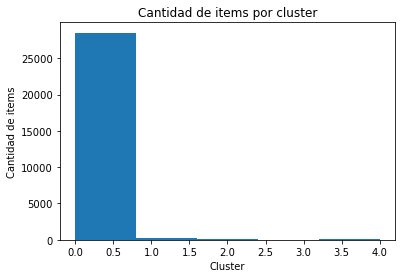

In [18]:
length_clusters = [len(cluster) for cluster in clusters.values()]
hist_data_clusters = []

for cluster, length in enumerate(length_clusters):
    print(f"Cluster #{cluster}: {length} items")
    hist_data_clusters.extend([cluster] * length)

plt.hist(hist_data_clusters, bins=N_CLUSTERS)
plt.title("Cantidad de items por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de items")
plt.show()

In [19]:
## Configuracion del grafico de puntos
LIM = 10000 # cantidad de puntos en el grafico
AXIS_1 = 0 # eje x
AXIS_2 = 1 # eje y
AXIS_3 = 3 # eje z

# colores de los clusters
CLUSTER_COLOR = ["red", "blue", "green", "yellow", "black",
                 "orange", "purple", "pink", "brown", "gray"]

* Graficando los puntos por cluster.


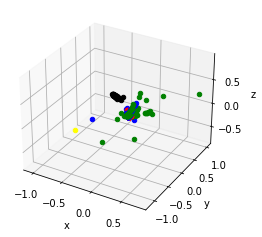

In [20]:
# Grafico
print("* Graficando los puntos por cluster.")

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for cluster, points in clusters.items():
    for point in points[:LIM]:
        ax.scatter(point[AXIS_1], point[AXIS_2], point[AXIS_3], color=CLUSTER_COLOR[cluster])    

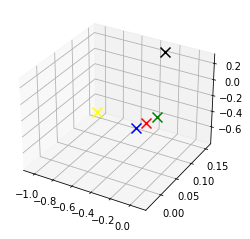

In [21]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for cluster, points in clusters.items():
    centroid = kmeans_model.clusterCenters()[cluster]
    ax.scatter(centroid[AXIS_1], centroid[AXIS_2], centroid[AXIS_3], color=CLUSTER_COLOR[cluster], marker="x", s=100)

In [22]:
def recommend_similar_items_v2(cluster_preds, model, group_id):
    # Recomiendo items que pertenecen al mismo cluster que el item dado

    # leo el cluster del item
    cluster_i = cluster_preds.filter(cluster_preds.id == group_id).select("prediction").collect()[0][0]

    # leo los items del cluster
    cluster_items = cluster_preds.filter(cluster_preds.prediction == cluster_i).select("id").collect()

    return cluster_items    

In [23]:
recommend_similar_items_v2(cluster_preds, model, item_id)[:10]

[Row(id=526420),
 Row(id=526480),
 Row(id=526640),
 Row(id=529800),
 Row(id=529820),
 Row(id=529830),
 Row(id=529940),
 Row(id=529990),
 Row(id=530420),
 Row(id=530430)]

#### Approach 3: Recomendacion indirecta

Como no esta implementada en la libreria, hago una "recomendacion indirecta":
> 1. Recomiendo $n$ usuarios para el item y almaceno su scoring en $V_k$ 
> 2. Veo las $t$ recomendaciones de items de cada uno de los usuarios y las almaceno en $S_{kj}$
> 3. Recomiendo $t*n$ items, con un scoring item-item $y_{ij}$...

Scoring del item $j$ recomendado al item $i$:

$$y_{ij} = \sum_{S_k = j} V_k * S_{kj}$$

In [133]:
def recommend_items_to_item_v3(model, group_id, n_users=10, n_items=100):
    
    # Recomiendo usuarios para el item dado:

    global spark

    item_df = uutils.from_list_to_df(spark, [group_id], "group_id") 
    item_recommendation = model.recommendForItemSubset(item_df, n_users)
    users_recommended = [(u_id, score) for u_id, score in item_recommendation.collect()[0][1]]

    # Recomiendo items para todo esos usuarios:
    users_df = uutils.from_list_to_df(spark, [u_id for u_id, _ in users_recommended], "user_id")
    users_recommendations = model.recommendForUserSubset(users_df, n_items)

    # Salida de la funcion  
    similar_items = dict()

    for user_id, user_scoring in users_recommended:
        
        # Recomiendo items para cada usuario recomendado
        item_recms = get_user_recommendations(users_recommendations, user_id)  
        
        for g_id, item_scoring in item_recms:
            
            # Me fijo si ya agregue al item
            if g_id in similar_items.keys():
                similar_items[g_id] += item_scoring * user_scoring                
            else:
                similar_items.update({g_id: item_scoring * user_scoring})

    # Ordeno por score
    similar_items = [(g_id, score) for g_id, score in similar_items.items()]
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)
    
    return similar_items

In [136]:
# recommend_items_to_item_v3(model, 790938, n_users=100, n_items=10)[:10]
# 19 mins!!!! 

## [5] Interpretar recomendaciones

In [24]:
interpreter = Interpreter(elastic_metadata="http://10.20.1.91:9200/common_clarovideo")

In [25]:
interpreter.describirItem(790938)

(790938,
 'Powers',
 'Series',
 'AMCO',
 'El detective Walker, ya sin poderes, debe vencer a sus demonios personales.')

In [26]:
n_items = 10 # cantidad de items a recomendar
item_id = 790938

# sumo una fila mas porque despues exluyo el primer item en orden, que es el mismo item
item_recm = recommend_similar_items_v1(model, item_id).limit(n_items+1)
item_recm_ids = [(row.id, 1-row.difference) for row in item_recm.collect()[1:]]

ignored, d = interpreter.interpretar_recomendaciones(item_id, item_recm_ids)
d

Item base:
(790938, 'Powers', 'Series', 'AMCO', 'El detective Walker, ya sin poderes, debe vencer a sus demonios personales.')


,id,nombre,genero,proveedor,descripcion
0,791002,Powers,Series,AMCO,Una droga letal que aumenta los poderes hace e...
1,1043847,La Prima,Comedia,AMCO,Luisa queda sumida en una encrucijada al no qu...
2,933072,Agente bajo fuego,suspenso,PARAMOUNT,"El agente del servicio secreto, Mike Banning e..."
3,1044683,Blade Runner 2049,acción,PARAMOUNT,Un joven corredor descubrirá una serie de secr...
4,1105072,"Claro Sports: Pelé, Long Live the King",Sports,AMCOEVENTOS,"Pelé, uno de los mejores jugadores de todos lo..."
5,1110702,Hawaii Five-0,Crimen,PARAMOUNT,Cuando un antiguo experto en ciberterrorismo e...
6,594284,Las tres pelonas,Drama,AMCO,En plena Revolución mexicana Salvador y María ...
7,747839,Zorro,Series,AMCO,Una amiga por correspondencia de Don Alejandro...
8,1028972,Yo Soy la Venganza,suspenso,PARAMOUNT,Un hombre inicia un camino de venganza contra ...
9,711356,El Torito,Comedia,AMCO,El personal debe compartir el estacionamiento ...


## [6] Metricas

#### Approach 1: Precision & Recall

In [33]:
def compute_precision(model, train, test, n_recs=100) -> float:

    # Computa la precision del modelo
    
    global spark
    
    print("* Armando interseccion de usuarios.")

    # items en cada ds
    users_in_test = set([i.user_id for i in test.select("user_id").collect()])
    users_in_train = set([i.user_id for i in train.select("user_id").collect()])    
    
    # items en comun
    shared_users = list(users_in_test.intersection(users_in_train))
    shared_users_df = uutils.from_list_to_df(spark, shared_users, "user_id")
    
    # recomiendo para items en comun
    print("* Haciendo recomendaciones para los usuarios.")
    recommendations = model.recommendForUserSubset(shared_users_df, n_recs)

    # inicializo la precision
    precision = 0
    recall = 0

    for i in trange(len(shared_users)):
        
        user_id = shared_users[i]
        
        # items recomendados
        items_recommended = get_user_recommendations(recommendations, user_id)
        items_recommended = [i for i, _ in items_recommended]
        
        # items en test
        items_in_test = [i.group_id for i in test.filter(test.user_id == user_id).collect()]
        
        # precision/recall para el usuario ~ en este caso son iguales porque n_recs es constante
        precision_user = len(set(items_recommended).intersection(set(items_in_test))) / n_recs
        
        # precision promedio
        precision += precision_user / len(shared_users)

    return precision
        

In [1]:
# compute_precision(model, train, test, n_recs=100)